In [3]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [6]:
s = []
prefix = "HH_object_ATTP_"
num_files = 6
for i in range(num_files):
    s.append(open("test-object-id-all-stats-0%d.txt" % i, "r").readlines())

In [7]:
raw_pr = []
raw_mem = []
raw_time = []
for i in range(num_files):
    ln = 0
    query_type = ""
    for line in s[i]:
        if line.startswith("Stats request at line"):
            ln = int(re.search("\d+", line).group())
        if line.find(" timers") != -1:
            query_type = line.strip().split(" ")[0]
        if line.find(" ms = ") != -1:
            t = line.strip().split(':')
            if t[0] != "EXACT_HH":
                sketch = t[0].split('-')
                sketch = [sketch[0], ''.join(sketch[1:])]
                raw_time.append(sketch + [ln, query_type, int(t[1].split("=")[1].strip()[:-3])])
        if line.find("prec") != -1:
            t = line.strip().split(':')
            if t[0] != "EXACT_HH":
                sketch = t[0].split('-')
                sketch = [sketch[0], ''.join(sketch[1:])]
                pr_info = t[1].split(",")
                try:
                    pr_info = list(map(lambda x: eval(x.split('=')[1].strip()), pr_info))
                except ZeroDivisionError:
                    continue
                raw_pr.append(sketch + ["Precision", pr_info[0]])
                raw_pr.append(sketch + ["Recall", pr_info[1]])
        if line.find("MB") != -1:
            t = line.strip().split(':')
            if t[0] != "EXACT_HH":
                sketch = t[0].split('-')
                t = [sketch[0], ''.join(sketch[1:]), ln, int(t[1].split("=")[0].strip()[:-2])]
                raw_mem.append(t)

In [8]:
mem_df = pd.DataFrame(raw_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage"])
mem_df

,Sketch,Param,Stream Size,Memory Usage
0,SAMPLING,ss100000,13528042,25606560
1,PCM_HH,logU23e0.001d0.01D2000,13528042,53017308
2,CMG,e0.001000,13528042,3434288
3,SAMPLING,ss100000,27056084,25610912
4,PCM_HH,logU23e0.001d0.01D2000,27056084,57779868
...,...,...,...,...
1813,PCM_HH,logU17e0.001d0.01D2000,1352804200,201638580
1814,CMG,e0.000800,1352804200,5269096
1815,SAMPLING,ss10000,1352804200,2920096
1816,PCM_HH,logU17e0.001d0.01D2000,1352804200,201638580


In [9]:
time_df = pd.DataFrame(raw_time, columns = ["Sketch", "Param", "Stream Size", "Type", "Value"])
time_df_processed = pd.merge(time_df, mem_df, on = ["Sketch", "Param", "Stream Size"]).drop_duplicates()
update_time_df = time_df_processed[time_df_processed["Type"] == "Update"]
update_time_df

,Sketch,Param,Stream Size,Type,Value,Memory Usage
0,SAMPLING,ss100000,13528042,Update,1238,25606560
2,PCM_HH,logU23e0.001d0.01D2000,13528042,Update,58995,53017308
4,CMG,e0.001000,13528042,Update,3539,3434288
6,SAMPLING,ss100000,27056084,Update,2394,25610912
8,PCM_HH,logU23e0.001d0.01D2000,27056084,Update,118241,57779868
...,...,...,...,...,...,...
3680,PCM_HH,logU17e0.001d0.01D2000,1339276158,Update,4993554,197811956
3682,CMG,e0.000800,1339276158,Update,389568,5257208
3684,SAMPLING,ss10000,1352804200,Update,112359,2920096
3692,PCM_HH,logU17e0.001d0.01D2000,1352804200,Update,5041425,201638580


In [10]:
pr_df = pd.DataFrame(raw_pr, columns = ["Sketch", "Param", "Metric", "Value"])
pr_df

,Sketch,Param,Metric,Value
0,SAMPLING,ss100000,Precision,1.000000
1,SAMPLING,ss100000,Recall,0.991561
2,CMG,e0.001000,Precision,0.871324
3,CMG,e0.001000,Recall,1.000000
4,SAMPLING,ss100000,Precision,0.995455
...,...,...,...,...
187,SAMPLING,ss10000,Recall,0.862500
188,PCM_HH,logU17e0.001d0.01D2000,Precision,0.924855
189,PCM_HH,logU17e0.001d0.01D2000,Recall,1.000000
190,CMG,e0.000800,Precision,0.677966


In [11]:
last_mem_df = mem_df.groupby(["Sketch", "Param"]).agg({"Memory Usage": "max"})
last_mem_df

NameError: name 'last_mem' is not defined

In [12]:
pr_df_processed = pd.DataFrame(pd.merge(pr_df, last_mem_df, on = ["Sketch", "Param"]).groupby(["Sketch", "Param", "Memory Usage", "Metric"]).mean().to_records())
pr_df_processed

,Sketch,Param,Memory Usage,Metric,Value
0,CMG,e0.000063,36643808,Precision,0.984154
1,CMG,e0.000063,36643808,Recall,1.000000
2,CMG,e0.000125,25389464,Precision,0.960490
3,CMG,e0.000125,25389464,Recall,1.000000
4,CMG,e0.000250,17374240,Precision,0.918770
5,CMG,e0.000250,17374240,Recall,1.000000
6,CMG,e0.000500,8413344,Precision,0.862021
7,CMG,e0.000500,8413344,Recall,1.000000
8,CMG,e0.000800,5269096,Precision,0.797934
9,CMG,e0.000800,5269096,Recall,1.000000


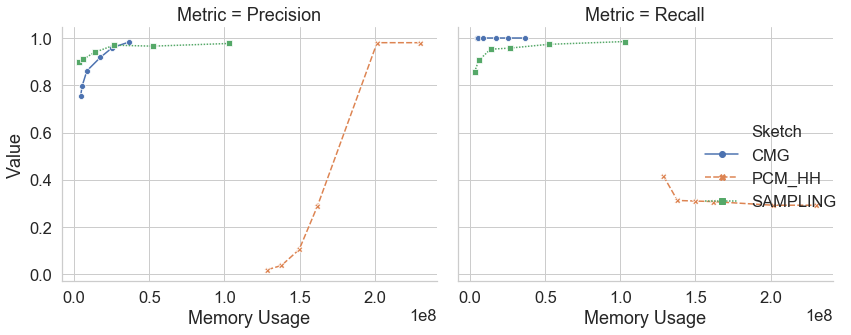

In [23]:
g = sns.relplot(x="Memory Usage", y="Value", hue="Sketch", style = "Sketch", col = "Metric", kind = "line",  markers=True,data=pr_df_processed)
plt.tight_layout()
plt.savefig(prefix + 'pr.pdf')

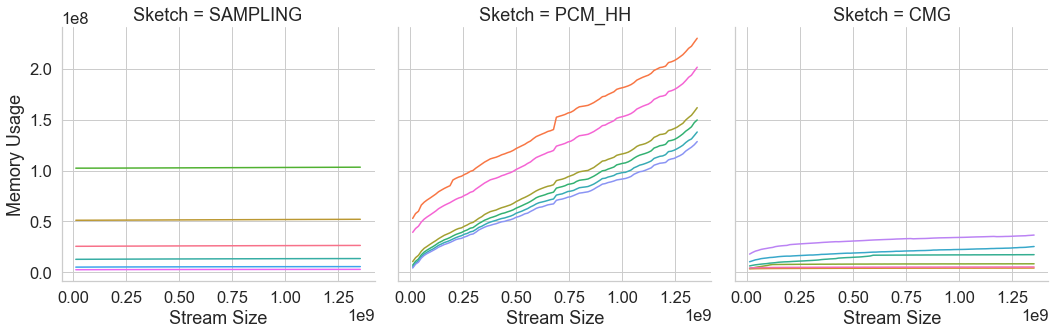

In [14]:
g = sns.relplot(x="Stream Size", y="Memory Usage", hue="Param", data=mem_df, dashes = False, col="Sketch",
                kind="line", legend=False)
plt.tight_layout()
plt.savefig(prefix + 'mem.pdf')

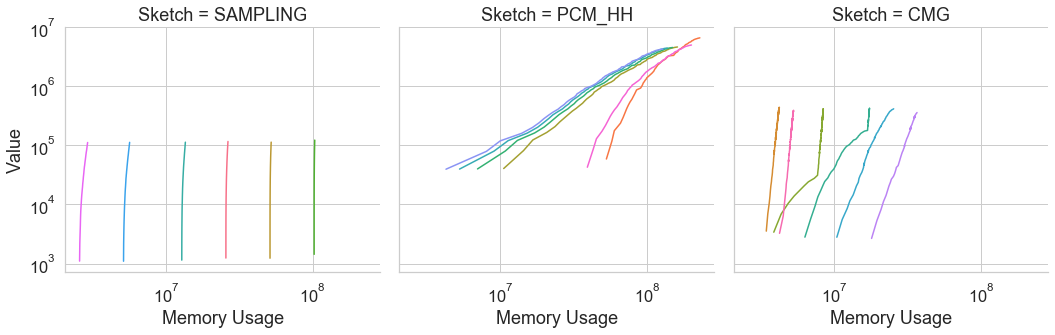

In [15]:
g = sns.relplot(x="Memory Usage", y="Value", hue="Param", style = "Param", col = "Sketch", kind = "line",  dashes = False, data=update_time_df, legend = False)
g.set(xscale = "log", yscale="log")
plt.tight_layout()
plt.savefig(prefix + 'time.pdf')